In [1]:
# Use vector graphics for plots. 
# Change the svg in next line to png and re-run everything via cell > run all, if your browser struggles.
%config InlineBackend.figure_format = 'svg'  

In [2]:
%pylab inline
pylab.rcParams['figure.dpi'] = 328
# Reduce the default size of the figures here a little bit
pylab.rcParams['figure.figsize'] = (5, 3)

Populating the interactive namespace from numpy and matplotlib


# Parameter Inference

In this tutorial we will see how to use parameter inference routines built into `MEANS` package.

Let's start by importing `MEANS` and other packages we are likely to need (e.g. numpy)

In [3]:
import means
import means.examples

In [4]:
import numpy as np

We will start with a simple parameter inference example: the dimerisation model:

In [5]:
model = means.examples.sample_models.MODEL_DIMERISATION

In [6]:
model

<class 'means.core.model.Model'>
Species: [y_0]
Parameters: [c_0, c_1, c_2]

Stoichiometry matrix:
Matrix([[-2, 2]])

Propensities:
Matrix([
[      c_0*y_0*(y_0 - 1)],
[c_1*(0.5*c_2 - 0.5*y_0)]])

We need to define the problem we want to work with first, as we will need to link the observed trajectories to the terms in this problem. 

Let's use MEA up to the maximum order of 2 to generate our problem:

In [7]:
problem = means.mea_approximation(model, 2)

## Collecting Observed Data

Once we have our problem, we can start defining the observed data.

Usually, the  data would be read from CSV or any other source that can be converted to a numpy array.
Here we simply write the data directly as a numpy array:

In [8]:
timepoints = np.arange(0, 20, 0.5)

In [9]:
observed_values = np.array([301.00, 290.19, 280.59, 272.03, 264.39, 
                            257.56, 251.44, 245.94, 241.01, 236.56, 
                            232.56, 228.95, 225.70, 222.75, 220.10, 
                            217.69, 215.51, 213.54, 211.76, 210.14,
                            208.67, 207.34, 206.13, 205.03, 204.04, 
                            203.13, 202.31, 201.56, 200.88, 200.27, 
                            199.71, 199.20, 198.73, 198.31, 197.93, 
                            197.58, 197.26, 196.97, 196.71, 196.47])

The data needs to be a list of ``Trajectory`` objects with the specific description field describing which equation the data is for.

Here we define that our data is for the first moment, corresponding to the ``y_0`` symbol in our problem. ``ODEProblem`` instances offer a convenient way of retrieving these descriptors via the ``.descriptor_for_symbol(symbol)`` method:

In [10]:
description = problem.descriptor_for_symbol('y_0')
description

Moment(array([1]), symbol=y_0)

We can now construct a ``Trajectory`` object and pass the required descriptor to it. 
Note that it is very important to encode your data into a ``Trajectory`` object with correct descriptor
as the system cannot guess which simulated trajectory to match it.

In [11]:
observed_trajectory = means.Trajectory(timepoints, 
                                       observed_values, 
                                       description)

We can plot this observed trajectory as any other trajectory:

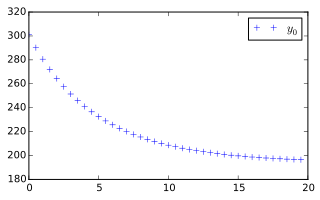

In [12]:
observed_trajectory.plot('+')
plt.legend()

## Creating the Inference Object

The infrence routines expect to get a list of observed trajectories, even if contains only a single element.

Let's wrap our trajectory we just defined around with the list brackets now, so we do not forget to do that later on.

In [13]:
observed_trajectories = [observed_trajectory]

We now need to define which parameters we make variable, and which ones we want to leave constant.
This is done by specifying a dictionary whose keys are the parameter/initial condition names, 
and the values are the allowed ranges for these parameters.

If a parameter is not listed in this dictionary, it is assumed to be constant.
If a range is set to `None`, the variable is assumed to be unbounded.

In [14]:
variable_parameters = {'c_0': (0, 0.001),
                       'c_1': (0, 0.5),
                        # No c_2 -> c_2 assumed constant
                       'y_0': None} # no range for y_0 -> y_0 is unbounded

Since the distance function minimisation must start at some point, we need to explicitly define the starting set of parameters and initial conditions:

In [15]:
# c_0, c_1, c_2 -> in the same order as problem.parameters
starting_parameters = [0.0001, 0.0001, 0.01] 
# y_0, in the same order as problem.left_hand_side
# values not set are assumed to be zero
starting_conditions = [300]                  
                                             

We can now perform parameter inference from some starting set of parameters. 
Inference class takes 7 parameters in the order demonstrated below. 

In [16]:
inference = means.Inference(problem,
                            starting_parameters,
                            starting_conditions,                 
                            variable_parameters,   
                            observed_trajectories,
                            )

## Performing inference and inspecting the results

To perform the inference, we need to call the ``infer()`` method of the newly created inference object:

In [17]:
result = inference.infer()

Could not find GLIMDA


We can see the summary of the output including the starting and optimal parameters, 
initial conditions, distance at minimum and the convergence status from just printing it:

In [18]:
print result


        <class 'means.inference.results.InferenceResult'>
        Starting Parameters: [0.0001, 0.0001, 0.01]
        Optimal Parameters: [4.8472999866748566e-05, 2.7683499719843729e-12, 0.01]

        Starting Initial Conditions: [300, 0.0]
        Optimal Initial Conditions: [274.3402361133725, 0.0]

        Distance at Minimum: 3885.3922259870715
        Convergence status: <Inference convergence achieved in 196 iterations and 357 function calls>
        


We can also plot the result using it's ``.plot()`` method:

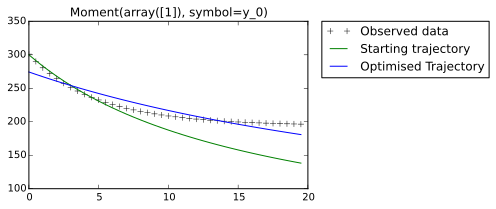

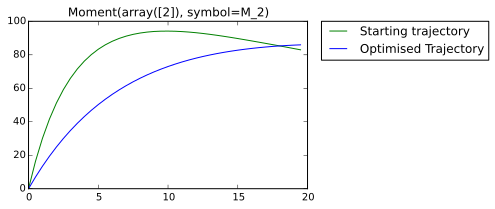

In [19]:
result.plot()

### Returning intermediate results

The parameter inference procedure can be told to return intermediate parameter sets considered and the trajectories that were used in the distance minimisation problem by setting ``return_intermediate_solutions`` parameter to `True` when calling ``Inference.infer()``.

Let's have a look:

In [20]:
result_with_interim_trajectories \
    = inference.infer(return_intermediate_solutions=True)

The resulting intermediate solutions are stored in the ``InferenceResult.solutions`` attribute.
This attribute returns a list of ``(parameter, initial_conditions)`` pairs:

In [21]:
# First three
solutions = result_with_interim_trajectories.solutions
for parameters, initial_conditions in solutions[:3]:
    print parameters, initial_conditions
print '... snip ...'
# Last five
for parameters, initial_conditions in solutions[-5:]:
    print parameters, initial_conditions
    

[0.0001, 0.0001, 0.01] [300.0, 0.0]
[9.0000000000000019e-05, 0.00010500000000000003, 0.01] [315.0, 0.0]
[9.0000000000000019e-05, 0.00010500000000000003, 0.01] [315.0, 0.0]
... snip ...
[4.8473108846467621e-05, 1.1700775165756097e-11, 0.01] [274.34025260839962, 0.0]
[4.8472999866748566e-05, 2.7683499719843729e-12, 0.01] [274.3402361133725, 0.0]
[4.8472999866748566e-05, 2.7683499719843729e-12, 0.01] [274.3402361133725, 0.0]
[4.8472999866748566e-05, 2.7683499719843729e-12, 0.01] [274.3402361133725, 0.0]
[4.8472999866748566e-05, 2.7683499719843729e-12, 0.01] [274.3402361133725, 0.0]


`MEANS` automatically plots these intermediate solutions, when they are available:

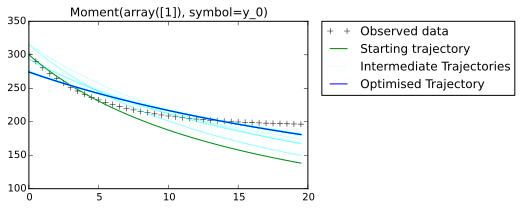

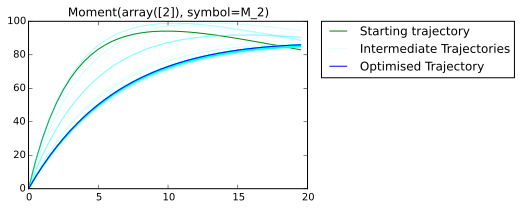

In [22]:
result_with_interim_trajectories.plot()

### Investigating distance landscape

It seems that our inference process shown earlier managed to converge to some parameter set. 
However, the resulting trajectory does not seem to be close to the observed data.

Local minima is a known problem for all optimisation algorithms.
We can hypothesise that our algorithm converged to a local minima.

We can verify this assumption by having a look at the distance landscape the solver has explored.
In order to do that, we need to run the inference with the ``return_distance_landscape`` parameter set to true as well.

In [23]:
result_with_distance_landscape \
    = inference.infer(return_intermediate_solutions=True, 
                      return_distance_landscape=True)

The resulting distance landscape is stored at the ``InferenceResult.distance_landscape`` attribute.

The output is a list of 3-tuples of form ``(parameters, initial_conditions, distance)``

In [24]:
# First three
distance_landscape = result_with_distance_landscape.distance_landscape
for parameters, initial_conditions, distance in distance_landscape[:3]:
    print parameters, initial_conditions, distance
print '... snip ...'
# Last five
for parameters, initial_conditions, distance in distance_landscape[-5:]:
    print parameters, initial_conditions, distance

[0.0001, 0.0001, 0.01] [300.0, 0.0] 36534.51216
[0.000105, 0.0001, 0.01] [300.0, 0.0] 43349.3299632
[0.0001, 0.000105, 0.01] [300.0, 0.0] 36550.3838478
... snip ...
[4.8473137059545633e-05, 6.2142555740766488e-12, 0.01] [274.34021723570783, 0.0] 3885.39222682
[4.8473176954803195e-05, -1.7477723352674016e-11, 0.01] [274.34028216160584, 0.0] inf
[4.8473034408979316e-05, 1.9080552032245567e-11, 0.01] [274.34021189793708, 0.0] 3885.392227
[4.8473129439528569e-05, -5.2916315577008223e-12, 0.01] [274.34025874038292, 0.0] inf
[4.8473058166616633e-05, 1.2987506134758969e-11, 0.01] [274.34022360854851, 0.0] 3885.39222667


`MEANS` provide a convenience functions to plot the distance landscape and intermediate solutions trajectory projections onto two variables, namely 
``plot_distance_landscape_projection`` and ``plot_trajectory_projection``.

Both of these functions take two parameters, ``x_axis`` and ``y_axis`` that specify the two dimensions to project the data onto.
We are going to plot all three projections available for our three variables ``c_0``, ``c_1``, ``c_2``.

/Users/saulius/.virtualenvs/means-dev/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/saulius/.virtualenvs/means-dev/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


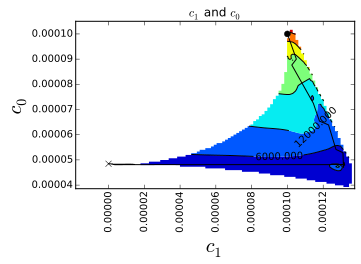

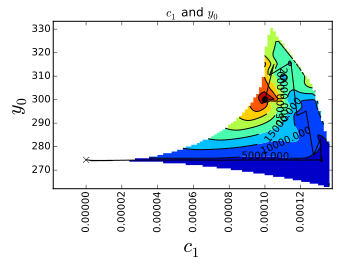

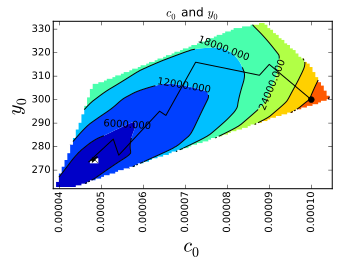

In [25]:
from itertools import combinations
for x_axis, y_axis in combinations(variable_parameters, 2):
    plt.figure()
    result_with_distance_landscape.plot_distance_landscape_projection(x_axis, 
                                                                      y_axis)
    result_with_distance_landscape.plot_trajectory_projection(x_axis, y_axis, 
                                                              color='black', 
                                                              start_marker='ko',
                                                              end_marker='kx')
    plt.title('${0}$ and ${1}$'.format(x_axis, y_axis))

We can see that the minimisation function has followed a clear downhill path towards the minima, and stayed there.
We can claim with reasonable certainty that the point inference converged to is a clear local minima of the problem. However, we cannot tell whether it is a global one. 

## Inference From Multiple Starting Points

To find other minima, which may as well be better than the current one, it is a a good idea to perform multiple optimisations from different starting points. MEANS package provides ``InferenceWithRestarts``; a convenience class for doing such optimisations.

First let's define the range where parameters and initial conditions are randomly sampled from:

In [26]:
parameters_range = [(0, 0.001), (0, 0.5), (260, 330)]
initial_conditions_range = [(290, 320)]

`MEANS` ``InferenceWithRestarts`` uses [Latin Hypercube sampling](https://mathieu.fenniak.net/latin-hypercube-sampling/) method to find the initial parameters for simulation.

Let's seed our random number generator so we can reproduce the same results (not strictly necessary, but helps us to reproduce the results in this tutorial).

In [27]:
import random
random.seed(42)
import numpy.random
numpy.random.seed(42)

We now create an ``InferenceWithRestarts`` instance we will use to perform a multiple parameter inference

In [28]:
NUMBER_OF_RESTARTS = 10
inference_with_restarts = means.InferenceWithRestarts(problem, 
                                                      NUMBER_OF_RESTARTS, 
                                                      parameters_range,
                                                      initial_conditions_range,
                                                      variable_parameters, 
                                                      observed_trajectories)

Note that it takes similar parameters as regular inference class, 
with the exception of additional number of restarts parameter, which specifies the number of restarts we expect to have.
In addition, the initial parameters and initial conditions are now ranges, not scalars.

We can now perform parameter inference using a similar ``infer()`` method. it is also possible to change the ``number_of_processes`` parameter to perform several inferences in parallel.

In [29]:
%%time 
multiple_inference_result = inference_with_restarts.infer(number_of_processes=1)
multiple_inference_result

CPU times: user 4.39 s, sys: 32.2 ms, total: 4.42 s
Wall time: 4.42 s


Once the inference is finished, we can plot it's result

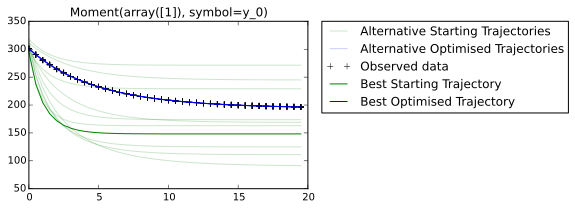

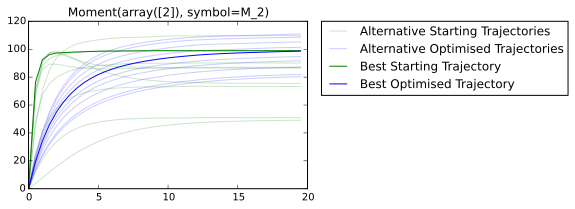

In [30]:
multiple_inference_result.plot()

Transparent lines show all but the best starting and optimised trajectories, while the solid lines show the best result.
This best result could be retrieved via ``best`` attribute of the result object.


        <class 'means.inference.results.InferenceResult'>
        Starting Parameters: [0.0009029797219438071, 0.26682972725563137, 296.6295362045272]
        Optimal Parameters: [0.00012473211149284562, 0.091403332985475066, 296.6295362045272]

        Starting Initial Conditions: [294.91999927956226, 0.0]
        Optimal Initial Conditions: [300.99131169502391, 0.0]

        Distance at Minimum: 0.0023300223202052032
        Convergence status: <Inference convergence achieved in 124 iterations and 217 function calls>
        


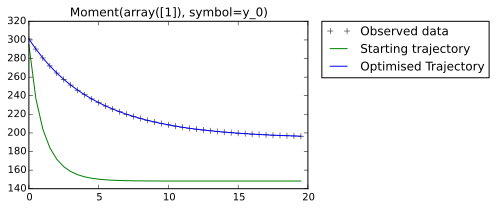

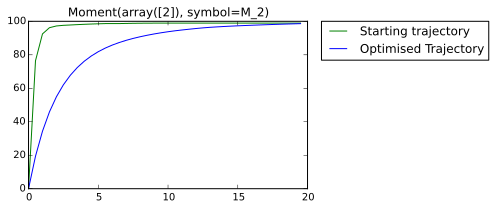

In [31]:
print multiple_inference_result.best
multiple_inference_result.best.plot()

## Distance Measures

Inference supports ``sum-of-squares``, ``gamma``, ``normal``, ``log-normal`` distance functions natively.

These functions can be selected by the ``distance_function_type`` parameter, i.e. ``distance_function_type='gamma'``. 

Consult the documentation for more information about the built-in distance functions.

The user of the software is also free to define custom distance functions.

The user-defined function should take two parameters:

- ``simulated_trajectories`` -- the trajectories simulated in the current iteration of inference
- ``observed_trajectories_lookup`` -- a dictionary of the format ``trajectory description: trajectory`` of the observed data

Let's try to define [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) function (otherwise known as Taxicab distance function), and use it to compare our trajectories.

Manhattan distance between two vectors $\mathbf{A} = (A_1, A_2, ..., A_n)$ and $\mathbf{B} = (B_1, B_2, ..., B_n)$ is usually defined as: 
    
$$ d(\mathbf{A}, \mathbf{B}) = \sum_i^n | A_i - B_i | $$

In [32]:
def manhattan_distance(simulated_trajectories, observed_trajectories_lookup):
    distance = 0

    for trajectory in simulated_trajectories:
        description = trajectory.description
        # Get observed trajectory that matches the simulated trajectory
        try:
            observed_trajectory = observed_trajectories_lookup[description]
        except KeyError:
            # If we do not have an equivalent observed trajectory, just continue
            continue
        
        values_a = trajectory.values
        values_b = observed_trajectory.values
        
        distance += np.sum(np.abs(values_a - values_b))
 
        
    return distance
        

Once we have our manhattan distance, let's create an inference object that would use it

In [33]:
inference_manhattan \
    = means.InferenceWithRestarts(problem, 
                                  NUMBER_OF_RESTARTS,
                                  parameters_range,
                                  initial_conditions_range,
                                  variable_parameters, 
                                  observed_trajectories,
                                  # Notice that we are passing in 
                                  # the function manhattan_distance here
                                  distance_function_type=manhattan_distance,
                                  )

In [34]:
manhattan_result = inference_manhattan.infer()

In [35]:
manhattan_result


        <class 'means.inference.results.InferenceResultsCollection'>

        Number of inference results in collection: 10
        Best:
        
        <class 'means.inference.results.InferenceResult'>
        Starting Parameters: [0.00038978228836024776, 0.3055776086797939, 297.26909239903273]
        Optimal Parameters: [0.00012510160844324757, 0.091111950901376193, 297.26909239903273]

        Starting Initial Conditions: [303.26941382060267, 0.0]
        Optimal Initial Conditions: [300.99813746257081, 0.0]

        Distance at Minimum: 0.2384995258137792
        Convergence status: <Inference convergence achieved in 131 iterations and 229 function calls>
        
        

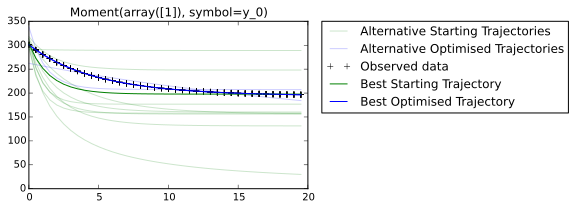

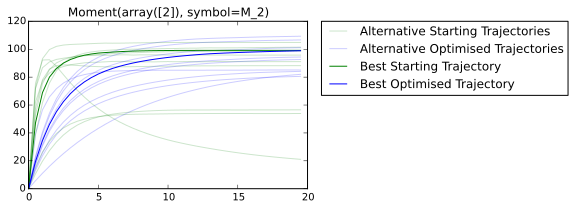

In [36]:
manhattan_result.plot()

In the next tutorial, we will explain in detail how to save and load `MEANS` objects.